In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('/content/names.txt', 'r').read().splitlines()

In [3]:
# build the vocab of chars and mappings to/from intergers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the data set
block_size = 3 # context length: how many chars do we take to predict the next one
def build_dataset(words):
   X, Y = [], []

   for w in words:
    context = [0] * block_size
    for ch in w + '.':
      idx = stoi[ch]
      X.append(context)
      Y.append(idx)
      context = context[1:] + [idx] # crop and append

   X=torch.tensor(X)
   Y=torch.tensor(Y)
   print(X.shape, Y.shape)
   return X, Y

In [5]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# Utility function that will be used later when comparinf manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item() # checking the gradients that we calculate with the gradients calculated by pytorch
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate {str(app):5s} | maxdiff: {maxdiff}')

In [7]:
from inspect import Parameter
# Initilization
n_embd = 10 # the dimensioanlity of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)

# layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5) # multiplying by the gain and divinding by the fan-in
b1 = torch.randn(n_hidden, generator=g) * 0.1 # might not be useful as we will use batch norm

# layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1

# batch norm parameters
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

# Initialized many of the parameters in non-standard ways because sometimes initializing with eg. all zeros could mask an incorrect implementation of backward pass

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True


4137


In [8]:
batch_size = 32

#contruct minibatch
idx = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
Xb, Yb = Xtr[idx], Ytr[idx] # batch X, Y

In [9]:
# forward pass

emb = C[Xb] # # shape: (batch_size, block_size, n_embd)
embcat = emb.view(emb.shape[0], -1)  # shape: (batch_size, block_size * n_embd)

# linear layer 1
hprebn = embcat @ W1 + b1 # shape: (batch_size, n_hidden), hidden layer pre-activation

# batch norm layer
bnmean_i = 1/batch_size*hprebn.sum(0, keepdim=True) # computes the mean of each hidden unit across the batch.
bndiff = hprebn - bnmean_i # centers the activations | helps gradient flow and symmetry in weight updates.
bndiff_sq = bndiff ** 2
bnvar = 1/(batch_size-1)*(bndiff_sq).sum(0, keepdim=True) # to scale the activation | High variance can lead to unstable gradients.
# NOTE: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5) ** -0.5 # inverse square root of variance for normalizing the scale of activations.
bnraw = bndiff * bnvar_inv # normalizes the centered activations. Produces zero-mean, unit-variance output | Stabilizes training and improves convergence speed.
hpreact = bngain * bnraw + bnbias # applies learnable scale (bngain) and shift (bnbias) to normalized activations | Prevents over-constraining the model; lets it learn richer representations.

# non-linearity
h = torch.tanh(hpreact) # hidden layer

# linear layer 2
logits = h @ W2 + b2 # output layer

# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
# Doing the above step to make sure that the logits do not become to large values as we are going to exponentiate them
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum ** -1.0 # if we use (1.0/counts_sum) instead then we will not get exact backbrop values
# We normalize in the above step to make sure the probs sum to 1
probs = counts * counts_sum_inv # notice that the shapes are not same (32, 27) & (32, 1)
# torch first broadcasts the values and then does the element wise multiplication
logprobs = probs.log()
loss = -logprobs[range(batch_size), Yb].mean()

# Pytorch bacward pass
for p in parameters:
  p.grad = None

for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, norm_logits,
          logit_maxes, logits, h, hpreact, bnraw, bnvar_inv, bnvar, bndiff_sq,
          bndiff, hprebn, bnmean_i, embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3586, grad_fn=<NegBackward0>)

In [ ]:
'''
loss = - (a + b + c)/3
loss = -1/3a + -1/3b + -1/3c
dloss/da = -1/n
'''

In [ ]:
'''
c = a * b, but with tensors
a[3X3] * b [3X1]
a11*b1 a12*b1 a13*b1
a21*b2 a22*b2 a23*b2
a31*b3 a32*b3 a33*b3
'''

In [ ]:
'''
counts.shape => (32, 27) and counts_sum.shape => (32, 1)

a11 a12 a13 ---> b1 (= a11 + a12 + a13)
a21 a22 a23 ---> b2 (= a21 + a22 + a23)
a31 a32 a33 ---> b3 (= a31 + a32 + a33)
'''

'\ncounts.shape => (32, 27) and counts_sum.shape => (32, 1)\n\na11 a12 a13 ---> b1 (= a11 + a12 + a13)\n'

In [ ]:
'''
norm_logits.shape => (32, 27), logits.shape => (32, 27) & logit_maxes.shape => (32, 1)
so again beware of broadcasting

c11 c12 c13 = a11 a12 a13   b1
c21 c22 c23 = a21 a22 a23 - b2
c31 c32 c33 = a31 a32 a33   b3

c32 = a32 - b3
'''

In [ ]:
#dlogits.shape, h.shape, W2.shape, b2.shape

(torch.Size([32, 27]),
 torch.Size([32, 64]),
 torch.Size([64, 27]),
 torch.Size([27]))

In [10]:
'''
bnvar = 1/(batch_size+1)*(bndiff_sq).sum(0, keepdim=True)
a11, a12
a21, a22

b1, b2
b1 = 1/(n-1)*(a11 + a21)
b2 = 1/(n-1)*(a12 + a22)
'''
bnvar.shape, bndiff_sq.shape

(torch.Size([1, 64]), torch.Size([32, 64]))

In [11]:
# Exercise 1: backprop through the while thing manually
# backpropagating through exactly all of the variables as they are defined in the forward pass above, one by one

dlogprobs = torch.zeros_like(logprobs) # create tensor in the shape of logprobs

dlogprobs[range(batch_size), Yb] = -1.0/batch_size
dprobs = (1.0 / probs) * dlogprobs # derivative of log(x) = 1/x, here x = probs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True) # sum for the broadcasting neing done for counts_sum_inv
dcounts = (counts_sum_inv * dprobs) # internally broadcasted
dcounts_sum = (-1.0 / counts_sum ** 2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = norm_logits.exp() * dcounts # = counts * dcounts (value wise)
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dlogits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes # can also be done in the way we calculated dlogprobs
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff_sq = (1.0/(batch_size-1))*torch.ones_like(bndiff_sq) * dbnvar
dbndiff += (2 * bndiff) * dbndiff_sq
dhprebn = dbndiff.clone()
dbnmean_i = ((-1.0)*dbndiff).sum(0)
dhprebn += (1.0/batch_size) * (torch.ones_like(hprebn)) * dbnmean_i
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC= torch.zeros_like(C)
for i in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    idx = Xb[i, j]
    dC[idx] += demb[i, j]

cmp('logprobs', dlogprobs, logprobs)
cmp('logprobs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnbias', dbnbias, bnbias)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff_sq', dbndiff_sq, bndiff_sq)
cmp('bndiff', dbndiff, bndiff)
cmp('hprebn', dhprebn, hprebn)
cmp('bnmean_i', dbnmean_i, bnmean_i)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate True  | maxdiff: 0.0
logprobs        | exact: True  | approximate True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate True  | maxdiff: 0.0
counts          | exact: True  | approximate True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate True  | maxdiff: 0.0
logits          | exact: True  | approximate True  | maxdiff: 0.0
h               | exact: True  | approximate True  | maxdiff: 0.0
W2              | exact: True  | approximate True  | maxdiff: 0.0
b2              | exact: True  | approximate True  | maxdiff: 0.0
hpreact         | exact: False | approximate True  | maxdiff: 4.656612873077393e-10
bngain          | exact: False | approximate True  | maxdiff: 1.862645149230957e-09
bnraw           | exact: False | approximate True  | maxdiff: 9.313225746154785e-10
bnbias          | exac

In [12]:
# Exercise 2: backprop through cross_entropy but all in one go

# forward pass

'''
before:
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
# Doing the above step to make sure that the logits do not become to large values as we are going to exponentiate them
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum ** -1.0 # if we use (1.0/counts_sum) instead then we will not get exact backbrop values
# We normalize in the above step to make sure the probs sum to 1
probs = counts * counts_sum_inv # notice that the shapes are not same (32, 27) & (32, 1)
# torch first broadcasts the values and then does the element wise multiplication
logprobs = probs.log()
loss = -logprobs[range(batch_size), Yb].mean()
'''

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff', (loss_fast-loss).item())

3.358550548553467 diff -4.76837158203125e-07


In [13]:
# backward pass

# derivative is p_i if i!=y else p_i-1
dlogits = F.softmax(logits, 1) # we can to do the softmax along the rows of the logits
dlogits[range(batch_size), Yb] -= 1 # for the elements that are at Yb subtract -1
dlogits /= batch_size # we need the average loss for the batch

cmp('logits', dlogits, logits)

logits          | exact: False | approximate True  | maxdiff: 6.51925802230835e-09


In [14]:
F.softmax(logits, 1)[0]

tensor([0.0703, 0.0898, 0.0195, 0.0465, 0.0206, 0.0769, 0.0254, 0.0365, 0.0178,
        0.0297, 0.0378, 0.0406, 0.0401, 0.0300, 0.0359, 0.0124, 0.0098, 0.0190,
        0.0172, 0.0530, 0.0495, 0.0195, 0.0297, 0.0712, 0.0529, 0.0266, 0.0216],
       grad_fn=<SelectBackward0>)

In [15]:
# dlogits is the probs matrix in the forward pass
# multiplying by batch_size so that we do not have the scaling by batch_size (avg)
dlogits[0]*batch_size # the place where we subtracted 1, so the correct indices

tensor([ 0.0703,  0.0898,  0.0195,  0.0465,  0.0206,  0.0769,  0.0254,  0.0365,
        -0.9822,  0.0297,  0.0378,  0.0406,  0.0401,  0.0300,  0.0359,  0.0124,
         0.0098,  0.0190,  0.0172,  0.0530,  0.0495,  0.0195,  0.0297,  0.0712,
         0.0529,  0.0266,  0.0216], grad_fn=<MulBackward0>)

In [16]:
dlogits[0].sum() # these sum up to zero -> the value maybe somethines be very to close to zero, python decimal calculation....

tensor(-2.7940e-09, grad_fn=<SumBackward0>)

In [ ]:
'''
the gradient at each cell is like a force where we try to push the correct probs up and pull the incorrect probs down,
and the amount of force applied to push and pull the probs sums to zero
the amount of force we apply to propotional to the probs that come out in the forward pass

if the probs were exactly correct then in that case,
we will have zero at all incorrect indices
and 1 at the correct index
and then in this cae dlogits will be all zero (0 by default at incorrect, and we subtract 1 for the correct, so it becomes zero as well)
'''

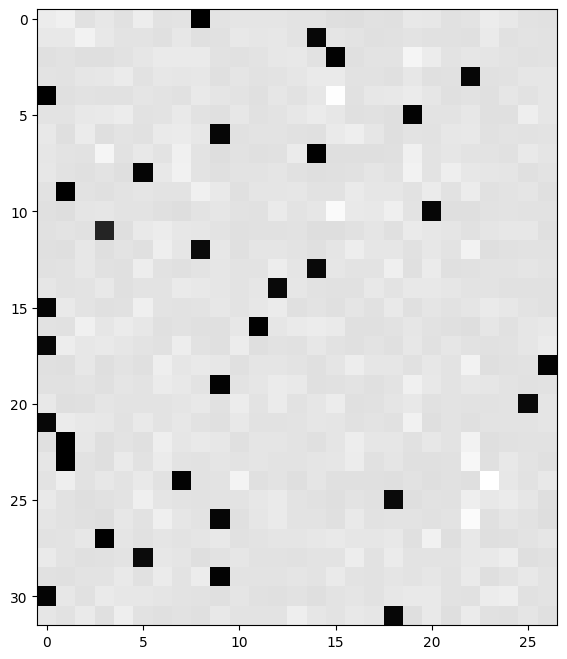

In [17]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')
# the black spots are the correct indices

In [18]:
# Exercise 3: backprop through batchnorm but all in one go

# forward pass

'''
before:

# batch norm layer
bnmean_i = 1/batch_size*hprebn.sum(0, keepdim=True) # computes the mean of each hidden unit across the batch.
bndiff = hprebn - bnmean_i # centers the activations | helps gradient flow and symmetry in weight updates.
bndiff_sq = bndiff ** 2
bnvar = 1/(batch_size+1)*(bndiff_sq).sum(0, keepdim=True) # to scale the activation | High variance can lead to unstable gradients.
# NOTE: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5) ** -0.5 # inverse square root of variance for normalizing the scale of activations.
bnraw = bndiff * bnvar_inv # normalizes the centered activations. Produces zero-mean, unit-variance output | Stabilizes training and improves convergence speed.
hpreact = bngain * bnraw + bnbias # applies learnable scale (bngain) and shift (bnbias) to normalized activations | Prevents over-constraining the model; lets it learn richer representations.
'''

# now:

hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [21]:
# backward pass

'''
before:

dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff_sq = (1.0/(batch_size-1))*torch.ones_like(bndiff_sq) * dbnvar
dbndiff += (2 * bndiff) * dbndiff_sq
dhprebn = dbndiff.clone()
dbnmean_i = ((-1.0)*dbndiff).sum(0)
dhprebn += (1.0/batch_size) * (torch.ones_like(hprebn)) * dbnmean_i
'''

#now:
dhprebn = ((bngain * bnvar_inv) / batch_size) * (batch_size * dhpreact - dhpreact.sum(0) - batch_size/(batch_size - 1) * bnraw * (dhpreact * bnraw).sum(0))
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate True  | maxdiff: 9.313225746154785e-10


In [62]:
# Exercise 4: Putting it all together
# Train the MLP neura; net with our own backward pass

n_embd = 10 # the dimensionality of the character embedding the vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)

# layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size) ** 0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1

# layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1

# batch norm parameters
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
loss_i = []

# use the following when not useing loss.backward
with torch.no_grad():

  # kick of optimization
  for i in range(max_steps):

    # mini batch construct
    idx = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[idx], Ytr[idx]

    # forward pass
    emb = C[Xb] # embed the vectors
    embcat = emb.view(emb.shape[0], -1) # concat the vectors
    # linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre activation
    # batch norm layer
    #---------------------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased = True)
    bnvar_inv = (bnvar + 1e-5) ** -0.5 # inv and sqrt
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    #---------------------------------------------------------------------------
    # non-leniarity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    #loss.backward() # uncomment this when not using manual backprop or for verification of manual answer

    # manual backprop!!! -------------------------------------------------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(batch_size), Yb] -= 1
    dlogits /= batch_size
    # 2nd layer
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # for tanh
    dhpreact = (1.0 - h**2) * dh
    # batch norm layer
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn =  (bngain * bnvar_inv / batch_size) * (batch_size * dhpreact - dhpreact.sum(0) - batch_size/(batch_size - 1) * bnraw * (dhpreact * bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # for embedding part
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for a in range(Xb.shape[0]):
      for b in range(Xb.shape[1]):
        c = Xb[a, b]
        dC[c] += demb[a, b]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias] #-------------------------


    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    loss_i.append(loss.log10().item())

    #if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    #  break

12297
      0/ 200000: 3.7294
  10000/ 200000: 2.1764
  20000/ 200000: 2.3869
  30000/ 200000: 2.5004
  40000/ 200000: 1.9757
  50000/ 200000: 2.3242
  60000/ 200000: 2.3282
  70000/ 200000: 1.9698
  80000/ 200000: 2.2784
  90000/ 200000: 2.2067
 100000/ 200000: 1.9002
 110000/ 200000: 2.3915
 120000/ 200000: 1.9416
 130000/ 200000: 2.4663
 140000/ 200000: 2.2794
 150000/ 200000: 2.0789
 160000/ 200000: 1.8816
 170000/ 200000: 1.8242
 180000/ 200000: 1.9948
 190000/ 200000: 1.9407


In [58]:
# for checking the gradients
for p, g in zip(parameters, grads):
  cmp(str(tuple(p.shape)), g, p)

(27, 10)        | exact: False | approximate True  | maxdiff: 1.30385160446167e-08
(30, 200)       | exact: False | approximate True  | maxdiff: 7.916241884231567e-09
(200,)          | exact: False | approximate True  | maxdiff: 5.587935447692871e-09
(200, 27)       | exact: False | approximate True  | maxdiff: 1.4901161193847656e-08
(27,)           | exact: False | approximate True  | maxdiff: 7.450580596923828e-09
(1, 200)        | exact: False | approximate True  | maxdiff: 3.026798367500305e-09
(1, 200)        | exact: False | approximate True  | maxdiff: 7.450580596923828e-09


In [63]:
# calliberate the batch norm at the end of the training

with torch.no_grad():
  # pass the training through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean, std dev over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True)

In [64]:
# evaluate train and val loss

@torch.no_grad() # disable the gradient tracking
def split_loss(split):
  x, y = {
      'train': {Xtr, Ytr},
      'val': {Xval, Yval},
      'test': {Xte, Yte},
  }[split]

  emb = C[x] # (batch_size, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat to (batch_size, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5) ** -0.5 + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.071078300476074
val 2.110525369644165


In [65]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1, block_size, d)
      embcat = emb.view(emb.shape[0], -1) # concat into (batch_size, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5) ** -0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mora.
mayah.
see.
mad.
rylle.
emman.
endraegusteredielin.
shi.
jen.
eden.
estanar.
kayzion.
kamin.
shubergshirael.
kindreelle.
jose.
casubented.
ryyah.
faeh.
yuma.
